In [1]:
import sys
sys.path.append('/opt/code/face/dual_shot')
import numpy as np
import keras.layers as KL
from keras import Model
from dual_conf import current_config as conf
from net.dual_shot import test_net
from prepare_data.generator import gen_test,layer_strides,map_size,e_scale,ratio
import os
from prepare_data.model_target import apply_regress,init_anchors

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
weight_path = os.path.join(conf.output_dir, 'weights.h5')
print('loading trained model from:',weight_path)

Using TensorFlow backend.
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


using: resnet50 as the base model
loading trained model from: /opt/code/face/dual_shot/train_out/weights.h5


## load model 

In [2]:
net_in = KL.Input([640, 640, 3], name='image_array')
ss_cls, ss_regr = test_net(net_in)
model = Model(inputs=[net_in], outputs=[ss_cls, ss_regr])
model.summary()
model.load_weights(weight_path, by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_array (InputLayer)        (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 646, 646, 3)  0           image_array[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 320, 320, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 320, 320, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## load data

In [3]:
gen = gen_test(1, 'train')
x_val,y_val = next(gen)
print(x_val.shape,y_val)

Error bbox number to filter : 48,  bbox number: 159376
(1, 640, 640, 3) [[[348.55643045 330.66666667 409.8687664  484.57142857]
  [194.01574803   0.         257.00787402  85.33333333]
  [153.7007874  516.57142857 209.97375328 640.        ]
  [528.29396325 422.0952381  596.32545932 560.76190476]
  [491.33858268 114.28571429 552.65091864 246.85714286]
  [328.39895013   0.         377.95275591  85.33333333]]]


## make prediction

In [4]:
def softmax(logit):
    assert len(logit.shape) == 2
    row_max = np.max(logit, axis=1)
    row_max = row_max[:, np.newaxis]
    logit = logit - row_max # make logit negtive to avoid infinity of e_x
    e_x = np.exp(logit)  
    row_sum = np.sum(e_x, axis=1)
    row_sum = row_sum[:, np.newaxis] 
    return e_x / row_sum

In [5]:
ss_cls,ss_regr= model.predict(x_val)
ss_cls,ss_regr= np.squeeze(ss_cls),np.squeeze(ss_regr)
ss_cls = softmax(ss_cls)
print(ss_cls.shape,ss_regr.shape)

(34125, 2) (34125, 4)


In [6]:
ss_cls

array([[0.8063934 , 0.19360659],
       [0.7871461 , 0.2128539 ],
       [0.7751882 , 0.22481175],
       ...,
       [0.882728  , 0.11727202],
       [0.70362926, 0.29637074],
       [0.35347453, 0.64652544]], dtype=float32)

In [7]:
# ss_cls = np.random.rand(4,conf.num_anchor,2)
# ss_regr = np.random.rand(4,conf.num_anchor,4)
# print(ss_cls.shape,ss_regr.shape)

## init anchors

In [8]:
e_anchors = init_anchors(layer_strides, map_size, ratio, e_scale)
e_anchors.shape

(34125, 4)

## apply delta 

In [9]:
pred_box = apply_regress(ss_regr,e_anchors)
pred_box.shape

(34125, 4)

In [10]:
pred_box.shape

(34125, 4)

## top 5k

In [11]:
pred_score = ss_cls[...,1]

In [12]:
sort_inds = np.argsort(-pred_score)

In [13]:
sort_inds

array([32472, 33315, 33451, ..., 33901, 33940, 33921])

In [14]:
pred_score = pred_score[sort_inds]
pred_box = pred_box[sort_inds]

In [15]:
pred_score =pred_score[:5000]
pred_box =pred_box[:5000,:]
print(pred_score.shape,pred_box.shape)

(5000,) (5000, 4)


In [16]:
pred_score

array([0.9999447 , 0.99990547, 0.99990296, ..., 0.18690808, 0.18683688,
       0.18677667], dtype=float32)

## nms

In [17]:
def bbox_vote(det):
    order = det[:, 4].ravel().argsort()[::-1]
    det = det[order, :]
    while det.shape[0] > 0:
        # IOU
        area = (det[:, 2] - det[:, 0] + 1) * (det[:, 3] - det[:, 1] + 1)
        xx1 = np.maximum(det[0, 0], det[:, 0])
        yy1 = np.maximum(det[0, 1], det[:, 1])
        xx2 = np.minimum(det[0, 2], det[:, 2])
        yy2 = np.minimum(det[0, 3], det[:, 3])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        o = inter / (area[0] + area[:] - inter)
        # get needed merge det and delete these det
        merge_index = np.where(o >= 0.3)[0]
        det_accu = det[merge_index, :]
        det = np.delete(det, merge_index, 0)
        if merge_index.shape[0] <= 1:
            continue
        det_accu[:, 0:4] = det_accu[:, 0:4] * np.tile(det_accu[:, -1:], (1, 4))
        max_score = np.max(det_accu[:, 4])
        det_accu_sum = np.zeros((1, 5))
        det_accu_sum[:, 0:4] = np.sum(det_accu[:, 0:4], axis=0) / np.sum(det_accu[:, -1:])
        det_accu_sum[:, 4] = max_score
        try:
            dets = np.row_stack((dets, det_accu_sum))
        except:
            dets = det_accu_sum
    dets = dets[dets[:, -1] > 0.8]  # ignore boxes with scores lower than 0.5
    dets = dets[0:750, :]
    return dets

In [18]:
pred_box.shape

(5000, 4)

In [19]:
det = np.concatenate([pred_box,np.expand_dims(pred_score,1)],axis=1)
final_box = bbox_vote(det)

In [20]:
final_box.shape

(61, 5)

In [21]:
final_box

array([[1.32453642e+02, 4.90626089e+02, 2.39194522e+02, 5.54404575e+02,
        9.99944687e-01],
       [4.58019254e+02, 5.28585068e+02, 5.59777005e+02, 6.05240981e+02,
        9.99905467e-01],
       [5.37961347e+02, 1.51234096e+02, 6.31208748e+02, 2.14864276e+02,
        9.99902964e-01],
       [1.00077432e+01, 3.23814029e+02, 7.84853769e+01, 3.77700103e+02,
        9.99888182e-01],
       [8.19094201e+00, 1.97528436e+02, 7.61621115e+01, 2.55703382e+02,
        9.99863029e-01],
       [3.60894514e+02, 3.48194289e+02, 4.72114359e+02, 4.15466588e+02,
        9.98654842e-01],
       [3.18841972e+00, 4.53226485e+02, 6.04594994e+01, 5.08457248e+02,
        9.98357832e-01],
       [4.70839794e+02, 4.54224085e+02, 5.03749483e+02, 4.81396521e+02,
        9.88566339e-01],
       [1.97338058e+02, 2.16376323e+02, 2.74177383e+02, 2.70757912e+02,
        9.86826301e-01],
       [4.17850796e+01, 2.60066253e+02, 6.73171736e+01, 2.77160405e+02,
        9.83869731e-01],
       [3.83569971e+00, 6.1437

## visualize

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_anchor(img_array, anchor_list):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img_array.astype(int))
    for a in anchor_list:
        y1,x1,y2,x2 = [int(i) for i in a]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


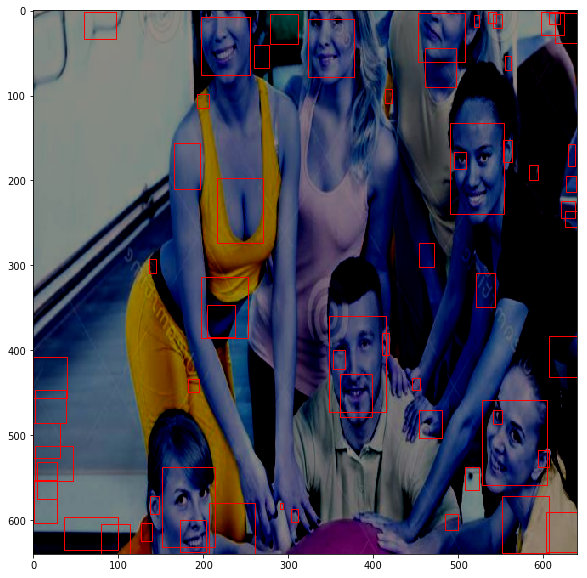

In [23]:
img_array = x_val[0]
anchor_list = final_box[:,:4]
plot_anchor(img_array, anchor_list)